## Analysis Testing Type I: Leave-One-Replicate-Out (LORO)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)
from sklearn.decomposition import PCA

import xgboost as xgb

import shap

import joblib

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Preprocessing


In [2]:
LATE_BOOT_DATES = ["2022-06-09", "2022-06-17", "2022-06-25", "2022-07-19"]

# load 2022 data
df_2022 = pd.read_csv("../../../Datasets/2022/Dataset_2022.csv")
df_2022 = df_2022.sort_values(by=["Date", "Plot_Number"])

# remove missing yield
df_2022 = df_2022[df_2022["Yield"].notna()]

# Only keep dates that occur on/before late booting stage
df_2022["Date"] = pd.to_datetime(df_2022["Date"]).dt.strftime("%Y-%m-%d")
df_2022 = df_2022[df_2022["Date"].isin(LATE_BOOT_DATES)]

# remove new indices from 2022
df_2022.drop(["DOY", "BNDVI", "LCI", "LAI"], axis=1, inplace=True)

**Split Plots into Train/Test** <br>
The split is done in a leave-one-replicate-out fashion. For each group of plots, one replicate is left out for validaiton while the rest is trained on.


In [3]:
seedCounter = 100
trainPlots = []
testPlots = []
tmp = df_2022[df_2022["Date"] == df_2022["Date"].unique()[0]]

for e in tmp["Experiment_Name"].unique():
    for c in tmp[tmp["Experiment_Name"] == e]["Rice_Cultivar"].unique():
        for n in tmp[(tmp["Experiment_Name"] == e) & (tmp["Rice_Cultivar"] == c)][
            "Nitrogen_Rate"
        ].unique():
            replicates = tmp[
                (tmp["Experiment_Name"] == e)
                & (tmp["Rice_Cultivar"] == c)
                & (tmp["Nitrogen_Rate"] == n)
            ]["Replicate"].unique()

            # set seed for each random pick for reproducibility
            np.random.seed(seedCounter)
            picked = np.random.choice(replicates)
            seedCounter += 1

            train = tmp[
                (tmp["Experiment_Name"] == e)
                & (tmp["Rice_Cultivar"] == c)
                & (tmp["Nitrogen_Rate"] == n)
                & (tmp["Replicate"] != picked)
            ]["Plot_Number"].values

            test = tmp[
                (tmp["Experiment_Name"] == e)
                & (tmp["Rice_Cultivar"] == c)
                & (tmp["Nitrogen_Rate"] == n)
                & (tmp["Replicate"] == picked)
            ]["Plot_Number"].values

            print(
                f"Experiment: {e}, Cultivar: {c}, Nitrogen: {n} \n"
                f"Train plots: {train}\n"
                f"Test plots: {test}\n"
                f"---------------------------------------------------------------"
            )

            trainPlots.extend(train)
            testPlots.extend(test)

del e, c, n, replicates, seedCounter, tmp

Experiment: Hybrid_RT7521FP, Cultivar: RT7521FP, Nitrogen: 130 
Train plots: [31770 31771 31772 31773 31774 31775 31776 31777 31778 31779 31780 31781
 31782 31783 31784 31785 31786 31787 31788 31789]
Test plots: [31760 31761 31762 31763 31764 31765 31766 31767 31768 31769]
---------------------------------------------------------------
Experiment: Inbred_Jeff + NIL, Cultivar: NIL 43, Nitrogen: 130 
Train plots: [31790 31793 31795 31797 31799 31810 31812 31816 31818 31819]
Test plots: [31802 31805 31807 31808 31809]
---------------------------------------------------------------
Experiment: Inbred_Jeff + NIL, Cultivar: Jefferson, Nitrogen: 130 
Train plots: [31800 31801 31803 31804 31806 31811 31813 31814 31815 31817]
Test plots: [31791 31792 31794 31796 31798]
---------------------------------------------------------------
Experiment: Mini_Core, Cultivar: EMBRAPA 1200, Nitrogen: 130 
Train plots: [31823 31832 31847]
Test plots: [31863]
--------------------------------------------------

In [4]:
dfTrain = df_2022[df_2022["Plot_Number"].isin(trainPlots)]
dfTest = df_2022[df_2022["Plot_Number"].isin(testPlots)]

# scale features
scaler = StandardScaler()
dfTrain.iloc[:, 17:] = scaler.fit_transform(dfTrain.iloc[:, 17:])
dfTest.iloc[:, 17:] = scaler.transform(dfTest.iloc[:, 17:])

dfUavTrain = dfTrain.iloc[:, 17:]
dfUavTest = dfTest.iloc[:, 17:]
dfLabelsTest = dfTest.iloc[:, :17]

# widen dataset
dfLongTestOriginal = pd.melt(
    dfTest.iloc[:, np.r_[0:8, 17 : len(dfTest.columns)]],
    id_vars=dfTest.iloc[:, 0:8],
    value_vars=dfTest.iloc[:, 17:],
)
dfWideTestOriginal = pd.pivot(
    dfLongTestOriginal,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Bay_Length",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()
dfWideTestOriginal.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTestOriginal.columns.tolist()
]

del dfLongTestOriginal

### Load Models


In [5]:
# load baseline model
nullModel = joblib.load("../Baseline_Model/Saved_Models/Baseline_LASSO")
nullModelExtra = joblib.load("../Baseline_Model/Saved_Models/Baseline_XGBoost")

# load modeling approach 1 models
pcaEmbedding = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_1/Saved_Models/PCA_EMBEDDING"
)
h1a1m1 = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_1/Saved_Models/H1A1M1"
)
h1a1m2 = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_1/Saved_Models/H1A1M2"
)

# load modeling approach 2 models
umapEmbedding = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_2/Saved_Models/UMAP_EMBEDDING"
)
h1a2m1 = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_2/Saved_Models/H1A2M1"
)
h1a2m2 = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_2/Saved_Models/H1A2M2"
)

### Transform and Preprocess Data (UMAP)


In [6]:
# transform test data into the new embedding
dfEmbeddingTestUMAP = pd.DataFrame(umapEmbedding.transform(dfUavTest))

# rename components
for i in range(0, len(dfEmbeddingTestUMAP.columns), 1):
    dfEmbeddingTestUMAP.rename(
        columns={dfEmbeddingTestUMAP.columns[i]: "UMAP_" + str(i + 1)},
        inplace=True,
    )

dfEmbeddingTestUMAP = pd.concat(
    [dfLabelsTest.reset_index(drop=True), dfEmbeddingTestUMAP], axis=1
)

# wide to long then long to wide
dfLongTestUMAP = pd.melt(
    dfEmbeddingTestUMAP.iloc[:, np.r_[0:8, 17 : len(dfEmbeddingTestUMAP.columns)]],
    id_vars=dfEmbeddingTestUMAP.iloc[:, 0:8],
    value_vars=dfEmbeddingTestUMAP.iloc[:, 17:],
)
dfWideTestUMAP = pd.pivot(
    dfLongTestUMAP,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Bay_Length",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()

dfWideTestUMAP.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTestUMAP.columns.tolist()
]

del dfLongTestUMAP, i

### Transform and Preprocess Data (PCA)


In [7]:
# transform test data into the new embedding
dfEmbeddingTestPCA = pd.DataFrame(pcaEmbedding.transform(dfUavTest))

# rename components
for i in range(0, len(dfEmbeddingTestPCA.columns), 1):
    dfEmbeddingTestPCA.rename(
        columns={dfEmbeddingTestPCA.columns[i]: "PCA_" + str(i + 1)},
        inplace=True,
    )

dfEmbeddingTestPCA = pd.concat(
    [dfLabelsTest.reset_index(drop=True), dfEmbeddingTestPCA], axis=1
)

# retain only first 10 PCs
dfEmbeddingTestPCA = dfEmbeddingTestPCA.loc[:, "Date":"PCA_10"]

# wide to long then long to wide
dfLongTestPCA = pd.melt(
    dfEmbeddingTestPCA.iloc[:, np.r_[0:8, 17 : len(dfEmbeddingTestPCA.columns)]],
    id_vars=dfEmbeddingTestPCA.iloc[:, 0:8],
    value_vars=dfEmbeddingTestPCA.iloc[:, 17:],
)
dfWideTestPCA = pd.pivot(
    dfLongTestPCA,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Bay_Length",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()

dfWideTestPCA.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTestPCA.columns.tolist()
]

del dfLongTestPCA, i

### Compute Predictions


In [8]:
results = dfWideTestOriginal.iloc[:, :7]

# null model
xTest = dfWideTestOriginal.iloc[:, 7:].values
yTest = dfWideTestOriginal["Yield"]
predictions = nullModel.predict(xTest)
results["Yield"] = yTest
results["Null_Model"] = predictions

print(
    f"Baseline Model (LASSO): "
    f"\nRMSE: {mean_squared_error(yTest, predictions, squared=False)}"
    f"\nMAE: {mean_absolute_error(yTest, predictions)}"
    f"\nMBE: {np.mean(predictions - yTest)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

xTest = dfWideTestOriginal.iloc[:, 7:].values
dtest = xgb.DMatrix(xTest, label=yTest)
predictions = nullModelExtra.predict(dtest)
results["Null_Model_Extra"] = predictions

print(
    f"Baseline Model (XGBoost): "
    f"\nRMSE: {mean_squared_error(yTest, predictions, squared=False)}"
    f"\nMAE: {mean_absolute_error(yTest, predictions)}"
    f"\nMBE: {np.mean(predictions - yTest)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# model always predicting the mean
predictions = [
    dfTrain[dfTrain["Date"] == dfTrain["Date"].unique()[0]]["Yield"].mean()
] * len(yTest)
results["Constant_Model"] = predictions

print(
    f"CONSTANT MODEL: "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# lasso pca
xTest = dfWideTestPCA.iloc[:, 7:].values
predictions = h1a1m1.predict(xTest)
results["Lasso_PCA"] = predictions

print(
    f"LASSO_PCA MODEL: "
    f"\nRMSE: {mean_squared_error(yTest, predictions, squared=False)}"
    f"\nMAE: {mean_absolute_error(yTest, predictions)}"
    f"\nMBE: {np.mean(predictions - yTest)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# xgboost pca
xTest = dfWideTestPCA.iloc[:, 7:].values
dtest = xgb.DMatrix(xTest, label=yTest)
predictions = h1a1m2.predict(dtest)
results["XGBoost_PCA"] = predictions

print(
    f"XGBOOST_PCA MODEL: "
    f"\nRMSE: {mean_squared_error(yTest, predictions, squared=False)}"
    f"\nMAE: {mean_absolute_error(yTest, predictions)}"
    f"\nMBE: {np.mean(predictions - yTest)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# lasso umap
xTest = dfWideTestUMAP.iloc[:, 7:].values
predictions = h1a2m1.predict(xTest)
results["Lasso_UMAP"] = predictions

print(
    f"LASSO_UMAP MODEL: "
    f"\nRMSE: {mean_squared_error(yTest, predictions, squared=False)}"
    f"\nMAE: {mean_absolute_error(yTest, predictions)}"
    f"\nMBE: {np.mean(predictions - yTest)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# xgboost umap
xTest = dfWideTestUMAP.iloc[:, 7:].values
dtest = xgb.DMatrix(xTest, label=yTest)
predictions = h1a2m2.predict(dtest)
results["XGBoost_UMAP"] = predictions

print(
    f"XGBOOST_UMAP MODEL: "
    f"\nRMSE: {mean_squared_error(yTest, predictions, squared=False)}"
    f"\nMAE: {mean_absolute_error(yTest, predictions)}"
    f"\nMBE: {np.mean(predictions - yTest)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

Baseline Model (LASSO): 
RMSE: 2.3283947668035445
MAE: 1.8352865057984367
MBE: -0.0183328058446728
MAPE: 0.3042
R^2: 0.6532
-----------------------------------------------------
Baseline Model (XGBoost): 
RMSE: 2.871058170477582
MAE: 2.36999913049006
MBE: -1.2939703943262069
MAPE: 0.3017
R^2: 0.4726
-----------------------------------------------------
CONSTANT MODEL: 
RMSE: 3.9537
MAE: 3.4304
MBE: 0.0366
MAPE: 0.5518
R^2: -0.0001
-----------------------------------------------------
LASSO_PCA MODEL: 
RMSE: 2.3450830967096747
MAE: 1.8593822270928049
MBE: -0.002690074747982855
MAPE: 0.3079
R^2: 0.6482
-----------------------------------------------------
XGBOOST_PCA MODEL: 
RMSE: 3.195208121990208
MAE: 2.7142625194725314
MBE: -1.4558694938708099
MAPE: 0.3586
R^2: 0.3468
-----------------------------------------------------
LASSO_UMAP MODEL: 
RMSE: 4.584044923212737
MAE: 3.684696006847736
MBE: 0.2424207568684629
MAPE: 0.5485
R^2: -0.3444
--------------------------------------------------

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


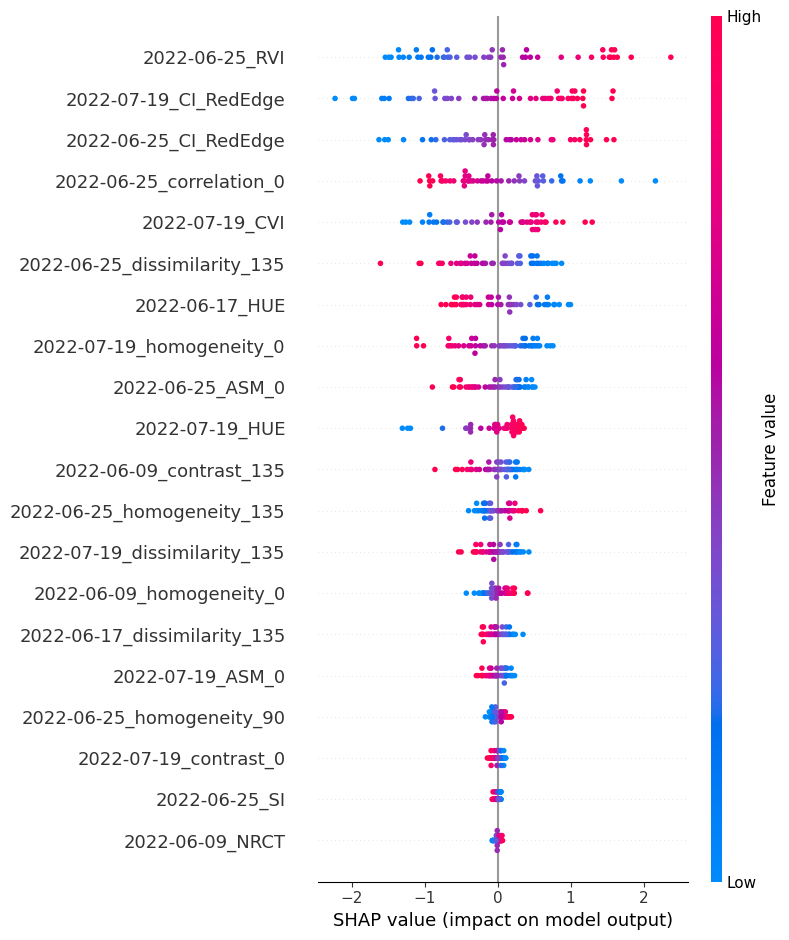

In [9]:
explainer = shap.Explainer(
    lambda x: nullModel.predict(x), dfWideTestOriginal.iloc[:, 7:].values
)
shapValues = explainer(dfWideTestOriginal.iloc[:, 7:].values)

shap.summary_plot(
    shapValues, plot_type="dot", feature_names=dfWideTestOriginal.columns[7:]
)

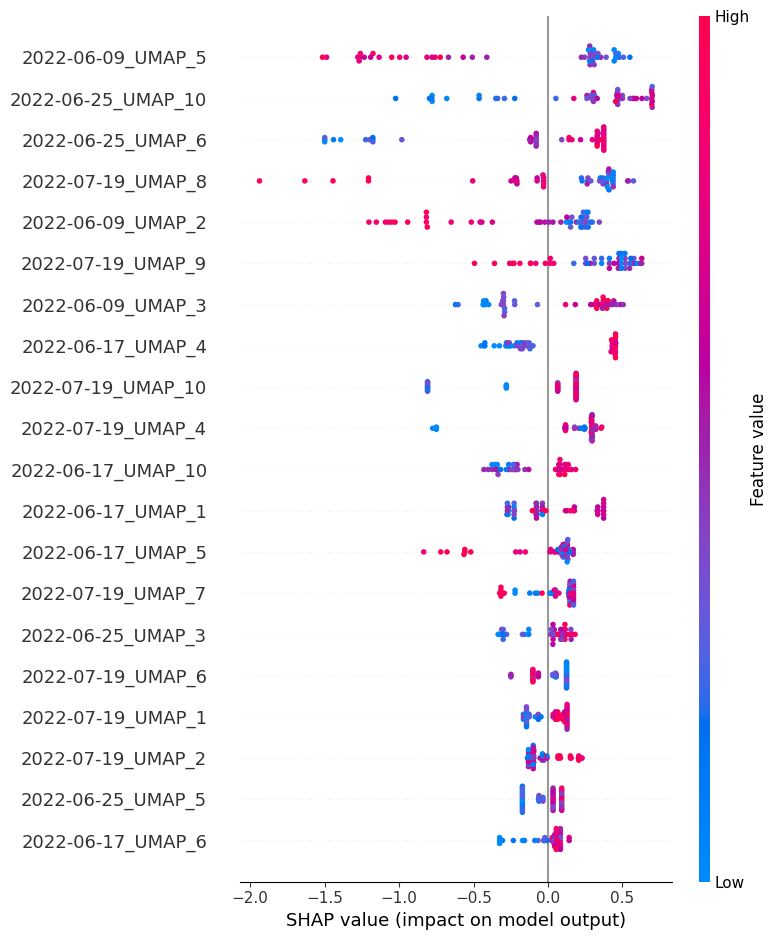

In [10]:
explainer = shap.Explainer(h1a2m2)
shapValues = explainer(dfWideTestUMAP.iloc[:, 7:].values)

shap.summary_plot(shapValues, plot_type="dot", feature_names=dfWideTestUMAP.columns[7:])

### Export Results


In [11]:
results.to_csv("../Outputs/predictions.csv", index=False)